# Social Media Extremism Detection Using Single-Layer Perceptron

In [9]:
# %% 
# 0. Imports & Global Config

import random
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from scipy.sparse import hstack, vstack, csr_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VaderAnalyzer

import torch
import torch.nn as nn
import torch.optim as optim

import shap

# Plot settings
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8, 5)

# Reproducibility
RANDOM_SEED = 30
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DATA_PATH = "extremism_data_final.csv"

# Feature settings
MAX_TOTAL_FEATURES = 20000
N_VADER_FEATURES = 4
MAX_TFIDF_FEATURES = MAX_TOTAL_FEATURES - N_VADER_FEATURES  # e.g. 19996

# Model/training settings
TEST_SIZE = 0.2
BATCH_SIZE = 32
HIDDEN_NEURONS = 512
LR = 0.1
EPOCHS = 130  # bump above 1 so you actually see curves
VAL_THRESHOLD = 0.5  # decision threshold for probs -> labels

In [2]:
# %%
# 1. Load the Dataset

df = pd.read_csv(DATA_PATH)

# Keep track of original row index so we can retrieve later
df["row_id"] = df.index

print("Dataset loaded. Shape:", df.shape)
df.head()

Dataset loaded. Shape: (2776, 3)


,Original_Message,Extremism_Label,row_id
0,sixth forms should burn to the ground,EXTREMIST,0
1,whatever should burn benders to the ground,EXTREMIST,1
2,factories should burn to the ground,EXTREMIST,2
3,halal factories should burn to the ground,EXTREMIST,3
4,nhs should burn to the ground,EXTREMIST,4


Label distribution:
Extremism_Label
NON_EXTREMIST    1454
EXTREMIST        1322
Name: count, dtype: int64

Label distribution (proportions):
Extremism_Label
NON_EXTREMIST    0.523775
EXTREMIST        0.476225
Name: proportion, dtype: float64


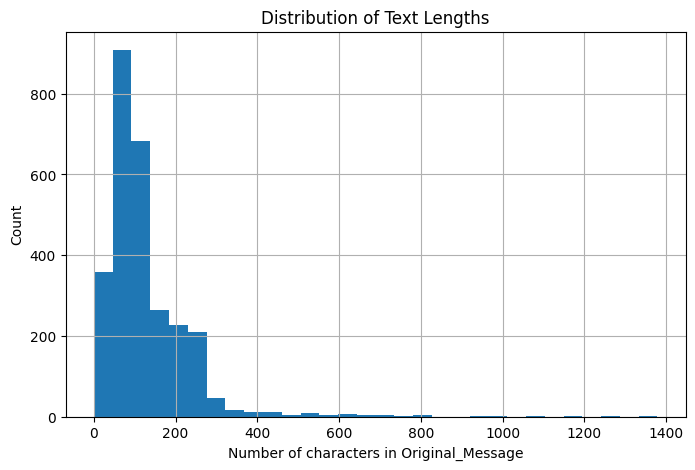

In [3]:
# %%
# 2. Encode labels and basic EDA

# Map EXTREMIST to 1, NON_EXTREMIST to 0
label_map = {
    "EXTREMIST": 1,
    "NON_EXTREMIST": 0,
}

df["Binary_Label"] = df["Extremism_Label"].map(label_map).astype(np.int64)
y = df["Binary_Label"].values

print("Label distribution:")
print(df["Extremism_Label"].value_counts())
print("\nLabel distribution (proportions):")
print(df["Extremism_Label"].value_counts(normalize=True))

# Quick text length distribution
text_lengths = df["Original_Message"].fillna("").astype(str).str.len()
plt.hist(text_lengths, bins=30)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of characters in Original_Message")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [4]:
# %%
# 3. Fit TF-IDF on the corpus and prepare VADER

texts = df["Original_Message"].fillna("").astype(str).tolist()

tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_TFIDF_FEATURES,
    min_df=3,
    ngram_range=(1, 3)
)
tfidf_vectorizer.fit(texts)

analyzer = VaderAnalyzer()

print("Number of TF-IDF features:", len(tfidf_vectorizer.get_feature_names_out()))

Number of TF-IDF features: 6870


In [5]:
# %%
# 4. Define vectorize_text(text) and build full feature matrix X

def vectorize_text(text: str):
    """
    Convert a single text string into a feature vector:
      [TF-IDF features | VADER neg, neu, pos, compound]
    Returns a sparse CSR matrix of shape (1, n_features).
    """
    # TF-IDF part
    X_tfidf = tfidf_vectorizer.transform([text])

    # VADER part
    scores = analyzer.polarity_scores(text)
    vader_vec = np.array([[scores["neg"], scores["neu"], scores["pos"], scores["compound"]]])
    X_vader = csr_matrix(vader_vec)

    # Concatenate horizontally
    X_full = hstack([X_tfidf, X_vader], format="csr")
    return X_full

# Apply vectorize_text() to each item
row_vectors = [
    vectorize_text(t) for t in df["Original_Message"].fillna("").astype(str)
]

X = vstack(row_vectors)   # shape: (n_samples, n_features)

print("Feature matrix shape:", X.shape)

# Build feature names: [TF-IDF tokens | VADER scores]
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out().tolist()
vader_feature_names = ["vader_neg", "vader_neu", "vader_pos", "vader_compound"]
feature_names = tfidf_feature_names + vader_feature_names

print("Total features in feature_names:", len(feature_names))
assert len(feature_names) == X.shape[1], "feature_names must match X columns"

Feature matrix shape: (2776, 6874)
Total features in feature_names: 6874


In [6]:
# %%
# 5. Training / validation split and tensor conversion

# Convert X and y to NumPy dense arrays
X_np = X.toarray().astype(np.float32)
y_np = y.astype(np.float32).reshape(-1, 1)

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_np,
    y_np,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y_np.reshape(-1),
)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train_np)
y_train = torch.from_numpy(y_train_np)

X_val = torch.from_numpy(X_val_np)
y_val = torch.from_numpy(y_val_np)

from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:  ", X_val.shape)
print("y_val shape:  ", y_val.shape)

X_train shape: torch.Size([2220, 6874])
y_train shape: torch.Size([2220, 1])
X_val shape:   torch.Size([556, 6874])
y_val shape:   torch.Size([556, 1])


In [25]:
# %%
# Reconstruct validation indices & texts WITHOUT retraining

# 1. All row indices
n_samples = len(df)
all_indices = np.arange(n_samples)

# 2. Use train_test_split on indices with SAME random_state & stratify
_, val_idx = train_test_split(
    all_indices,
    test_size=0.2,           # must match your original split
    random_state=30,         # must match your original split
    stratify=y               # same stratify target
)

# 3. Build texts_val array aligned with X_val / X_val_explain
texts_all = df["Original_Message"].fillna("").astype(str).values
texts_val = texts_all[val_idx]

print("Validation size:", len(texts_val))
print("Example validation text:", texts_val[0])

Validation size: 556
Example validation text: kashmir countries sponsoring terrorism must be held accountable pm mode at in bishkek kyrgyzstan terrorismfreekashmir modiscotoughtalk modiexposespak pakistan dawn freebalochistan pashtun terroristnationpakistan cpc


In [7]:
# %%
# 6. Model definition and optimizer

class SingleLayerNet(nn.Module):
    def __init__(self, input_size, hidden_neurons, output_size):
        super(SingleLayerNet, self).__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_neurons)
        self.output_layer = nn.Linear(hidden_neurons, output_size)
        
    def forward(self, x):
        hidden_output = torch.sigmoid(self.hidden_layer(x))
        y_pred = torch.sigmoid(self.output_layer(hidden_output))
        return y_pred

input_size = X_train.shape[1]
output_size = 1  # binary

model2 = SingleLayerNet(input_size, HIDDEN_NEURONS, output_size)
print(model2)

def criterion(y_pred, y_true):
    eps = 1e-8
    loss = -1 * (y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))
    return torch.mean(loss)

optimizer = optim.SGD(model2.parameters(), lr=LR)

SingleLayerNet(
  (hidden_layer): Linear(in_features=6874, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=1, bias=True)
)


In [10]:
# %%
# 7. Training loop with metric tracking

train_losses = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0
best_epoch = None
best_state_dict = None

for epoch in range(EPOCHS):
    # ----- TRAIN -----
    model2.train()
    total_train_loss = 0.0
    total_train_examples = 0

    for xb, yb in train_loader:
        y_pred = model2(xb)
        loss = criterion(y_pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_size = xb.size(0)
        total_train_loss += loss.item() * batch_size
        total_train_examples += batch_size

    avg_train_loss = total_train_loss / total_train_examples
    train_losses.append(avg_train_loss)

    # ----- VALIDATION -----
    model2.eval()
    with torch.no_grad():
        y_val_pred = model2(X_val)
        val_loss = criterion(y_val_pred, y_val).item()
        val_losses.append(val_loss)

        y_val_pred_labels = (y_val_pred >= VAL_THRESHOLD).float()
        correct = (y_val_pred_labels == y_val).sum().item()
        total = y_val.shape[0]
        val_acc = correct / total
        val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_state_dict = model2.state_dict()

    print(
        f"Epoch {epoch+1}/{EPOCHS} - "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

print(f"\nBest validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
model2.load_state_dict(best_state_dict)

Epoch 1/130 - Train Loss: 1.1933 | Val Loss: 0.9069 | Val Acc: 0.5234
Epoch 2/130 - Train Loss: 1.1908 | Val Loss: 0.7640 | Val Acc: 0.5234
Epoch 3/130 - Train Loss: 1.2268 | Val Loss: 0.8406 | Val Acc: 0.5234
Epoch 4/130 - Train Loss: 1.1081 | Val Loss: 0.7125 | Val Acc: 0.4766
Epoch 5/130 - Train Loss: 0.9541 | Val Loss: 1.2239 | Val Acc: 0.5234
Epoch 6/130 - Train Loss: 1.0131 | Val Loss: 1.5346 | Val Acc: 0.4766
Epoch 7/130 - Train Loss: 1.0604 | Val Loss: 1.0143 | Val Acc: 0.4766
Epoch 8/130 - Train Loss: 1.0823 | Val Loss: 1.8471 | Val Acc: 0.5234
Epoch 9/130 - Train Loss: 0.9437 | Val Loss: 0.7675 | Val Acc: 0.5234
Epoch 10/130 - Train Loss: 1.0357 | Val Loss: 2.2191 | Val Acc: 0.5234
Epoch 11/130 - Train Loss: 1.0073 | Val Loss: 0.8225 | Val Acc: 0.5234
Epoch 12/130 - Train Loss: 0.9909 | Val Loss: 0.6842 | Val Acc: 0.5504
Epoch 13/130 - Train Loss: 1.1174 | Val Loss: 1.0574 | Val Acc: 0.4766
Epoch 14/130 - Train Loss: 1.0768 | Val Loss: 0.9965 | Val Acc: 0.5234
Epoch 15/130 - 

<All keys matched successfully>

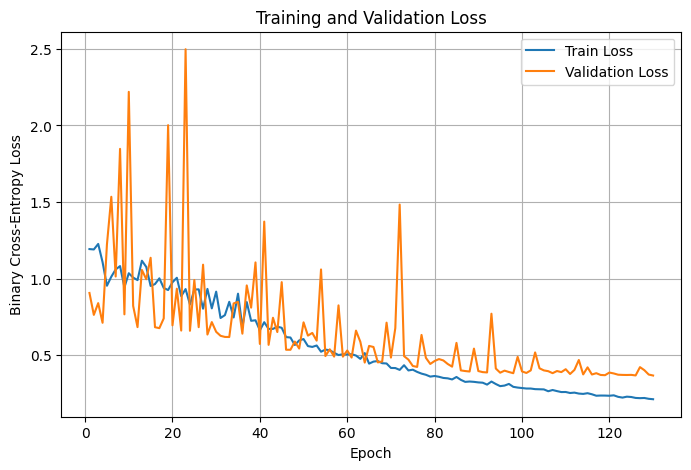

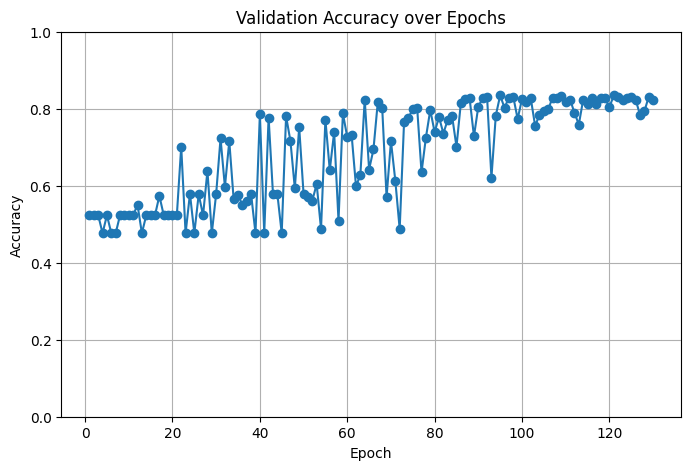

In [11]:
# %%
# 8. Plot training & validation curves

epochs_range = range(1, EPOCHS + 1)

plt.figure()
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs_range, val_accuracies, marker="o")
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Sklearn metrics on validation set (Neural net model):
Accuracy:      0.8219
F1 (macro):    0.8216
F1 (weighted): 0.8220

Classification report:
               precision    recall  f1-score   support

NON_EXTREMIST       0.83      0.82      0.83       291
    EXTREMIST       0.81      0.82      0.81       265

     accuracy                           0.82       556
    macro avg       0.82      0.82      0.82       556
 weighted avg       0.82      0.82      0.82       556

Confusion matrix:
[[240  51]
 [ 48 217]]


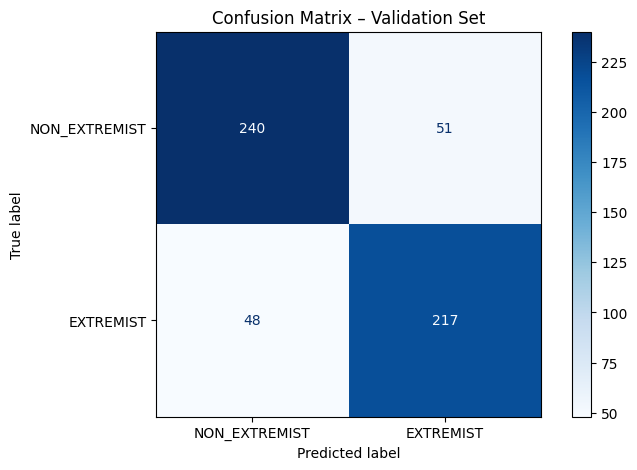

In [12]:
# %%
# 9. Final evaluation on validation set

model2.eval()
with torch.no_grad():
    y_val_pred = model2(X_val).cpu().numpy().ravel()

y_val_true = y_val.cpu().numpy().ravel().astype(int)
y_val_pred_labels = (y_val_pred >= VAL_THRESHOLD).astype(int)

acc = accuracy_score(y_val_true, y_val_pred_labels)
f1_macro = f1_score(y_val_true, y_val_pred_labels, average="macro")
f1_weighted = f1_score(y_val_true, y_val_pred_labels, average="weighted")

print("Sklearn metrics on validation set (Neural net model):")
print(f"Accuracy:      {acc:.4f}")
print(f"F1 (macro):    {f1_macro:.4f}")
print(f"F1 (weighted): {f1_weighted:.4f}\n")

print("Classification report:")
print(classification_report(y_val_true, y_val_pred_labels, target_names=["NON_EXTREMIST", "EXTREMIST"]))

print("Confusion matrix:")
cm = confusion_matrix(y_val_true, y_val_pred_labels)
print(cm)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["NON_EXTREMIST", "EXTREMIST"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Validation Set")
plt.show()

In [27]:
# %%
# Extra metrics table (per-class, macro, weighted)

from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(
    y_val_true,
    y_val_pred_labels,
    target_names=["NON_EXTREMIST", "EXTREMIST"],
    output_dict=True,
)

metrics_df = pd.DataFrame(report_dict).T
print("Detailed classification report as table:")
display(metrics_df)

Detailed classification report as table:


,precision,recall,f1-score,support
NON_EXTREMIST,0.833333,0.824742,0.829016,291.000000
EXTREMIST,0.809701,0.818868,0.814259,265.000000
accuracy,0.821942,0.821942,0.821942,0.821942
macro avg,0.821517,0.821805,0.821637,556.000000
weighted avg,0.822070,0.821942,0.821982,556.000000


ROC AUC: 0.9153


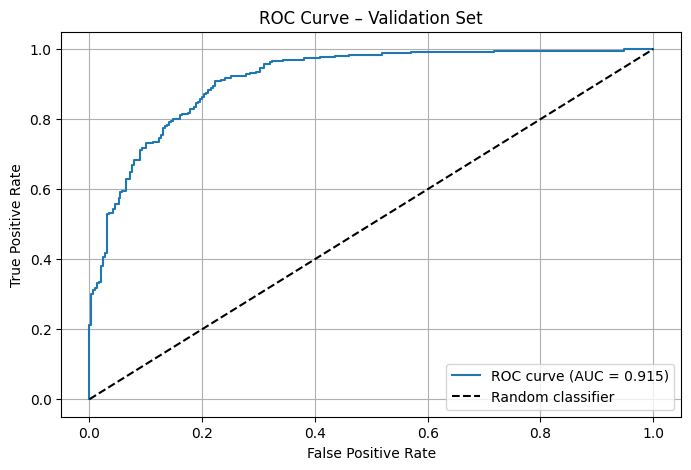

In [28]:
# %%
# ROC curve and ROC AUC

from sklearn.metrics import roc_curve, roc_auc_score

# fpr = false positive rate, tpr = true positive rate
fpr, tpr, roc_thresholds = roc_curve(y_val_true, y_val_pred)
roc_auc = roc_auc_score(y_val_true, y_val_pred)

print(f"ROC AUC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random classifier")
plt.title("ROC Curve – Validation Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Average Precision (AP): 0.9044


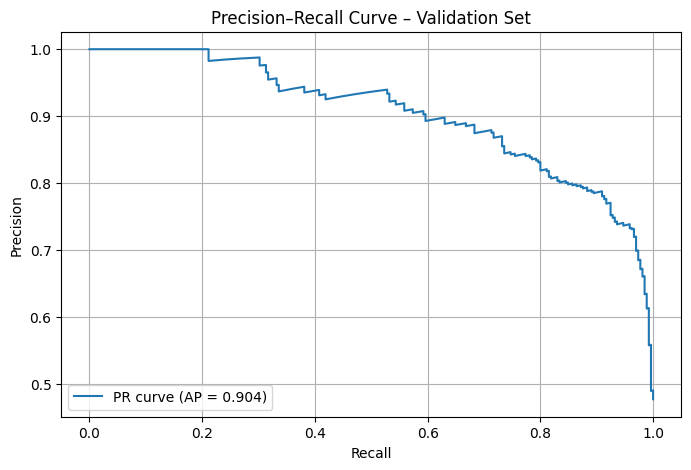

In [29]:
# %%
# Precision–Recall curve and Average Precision (AP)

from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, pr_thresholds = precision_recall_curve(y_val_true, y_val_pred)
ap = average_precision_score(y_val_true, y_val_pred)

print(f"Average Precision (AP): {ap:.4f}")

plt.figure()
plt.plot(recall, precision, label=f"PR curve (AP = {ap:.3f})")
plt.title("Precision–Recall Curve – Validation Set")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [30]:
# %%
# Log loss and Brier score

from sklearn.metrics import log_loss, brier_score_loss

ll = log_loss(y_val_true, y_val_pred)
brier = brier_score_loss(y_val_true, y_val_pred)

print(f"Log loss:       {ll:.4f}")
print(f"Brier score:    {brier:.4f}")

Log loss:       0.3684
Brier score:    0.1168


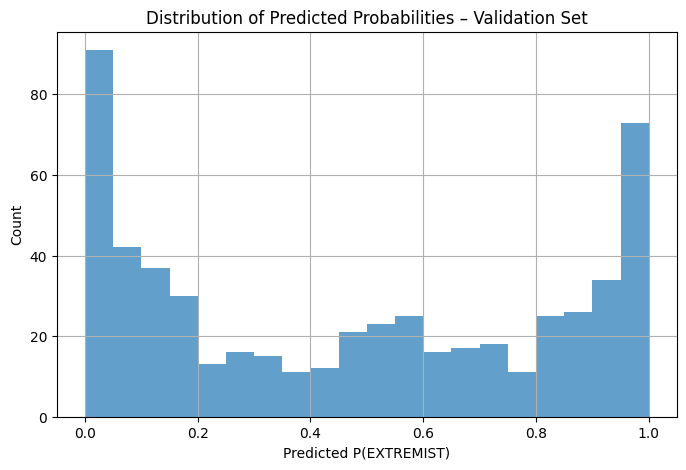

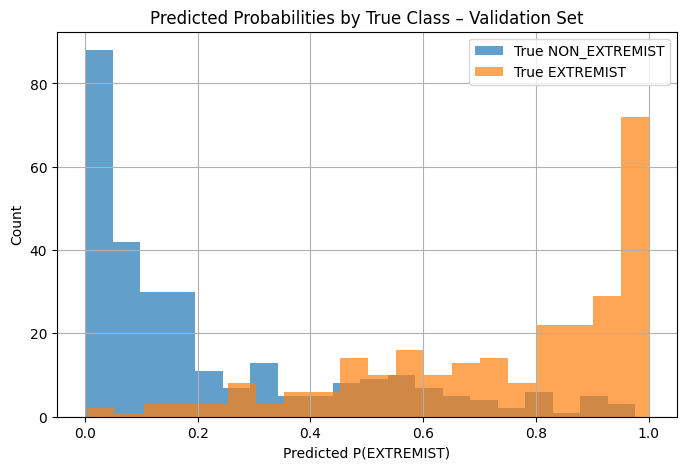

In [31]:
# %%
# Probability histograms (overall and per-class)

plt.figure()
plt.hist(y_val_pred, bins=20, alpha=0.7)
plt.title("Distribution of Predicted Probabilities – Validation Set")
plt.xlabel("Predicted P(EXTREMIST)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

plt.figure()
plt.hist(y_val_pred[y_val_true == 0], bins=20, alpha=0.7, label="True NON_EXTREMIST")
plt.hist(y_val_pred[y_val_true == 1], bins=20, alpha=0.7, label="True EXTREMIST")
plt.title("Predicted Probabilities by True Class – Validation Set")
plt.xlabel("Predicted P(EXTREMIST)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# %%
# 10. SHAP setup for model2

shap.initjs()
model2.eval()

def model2_predict(x_np):
    with torch.no_grad():
        x_tensor = torch.from_numpy(x_np.astype(np.float32))
        probs = model2(x_tensor).cpu().numpy().ravel()
    return probs

# Summarize the background with K representative samples
K = 100  # tradeoff between speed and accuracy
background = shap.kmeans(X_train_np, K)

explainer = shap.KernelExplainer(model2_predict, background)

In [14]:
# %%
# 11. Compute SHAP values for a subset of the validation set

explain_size = min(200, X_val_np.shape[0])
X_val_explain = X_val_np[:explain_size]

shap_values = explainer.shap_values(X_val_explain)

if isinstance(shap_values, list):
    shap_values = shap_values[0]

shap_values = np.array(shap_values)

print("X_val_explain shape:", X_val_explain.shape)
print("SHAP values shape:  ", shap_values.shape)

  0%|          | 0/200 [00:00<?, ?it/s]

X_val_explain shape: (200, 6874)
SHAP values shape:   (200, 6874)


In [32]:
# %%
# Build a global SHAP Explanation object for the explained subset

import numpy as np
import shap

global_exp = shap.Explanation(
    values=shap_values,                                      # (n_samples, n_features)
    base_values=np.repeat(explainer.expected_value, shap_values.shape[0]),
    data=X_val_explain,                                      # (n_samples, n_features)
    feature_names=feature_names
)

print(global_exp)

.values =
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.01545625,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.02435903, -0.00048256],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.00379882,  0.00141936],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.01477073,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.00696196,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.01907381,  0.        ]])

.base_values =
array([0.42051176, 0.42051176, 0.42051176, 0.42051176, 0.42051176,
       0.42051176, 0.42051176, 0.42051176, 0.42051176, 0.42051176,
       0.42051176, 0.42051176, 0.42051176, 0.42051176, 0.42051176,
       0.42051176, 0.42051176, 0.42051176, 0.42051176, 0.42051176,
       0.42051176, 0.42051176, 0.42051176, 0.42051176, 0.42051176,
       0.42051176, 0.42051

Validation example index: 0
Original message:
kashmir countries sponsoring terrorism must be held accountable pm mode at in bishkek kyrgyzstan terrorismfreekashmir modiscotoughtalk modiexposespak pakistan dawn freebalochistan pashtun terroristnationpakistan cpc
--------------------------------------------------------------------------------


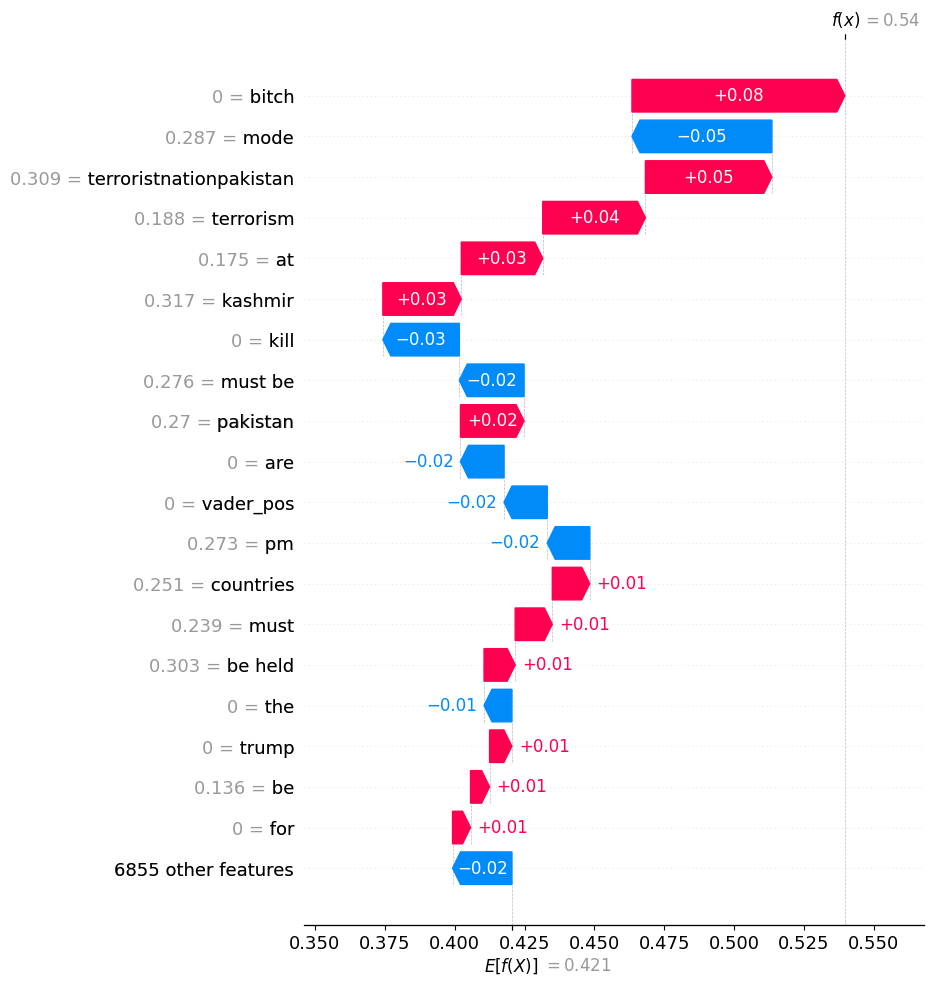

In [26]:
# %%
# Waterfall plot + print original sentence (no retrain version)

import shap

i = 0  # pick any index in [0, explain_size)

print(f"Validation example index: {i}")
print("Original message:")
print(texts_val[i])
print("-" * 80)

exp = shap.Explanation(
    values=shap_values[i],
    base_values=explainer.expected_value,
    data=X_val_explain[i],
    feature_names=feature_names
)

shap.plots.waterfall(exp, max_display=20)

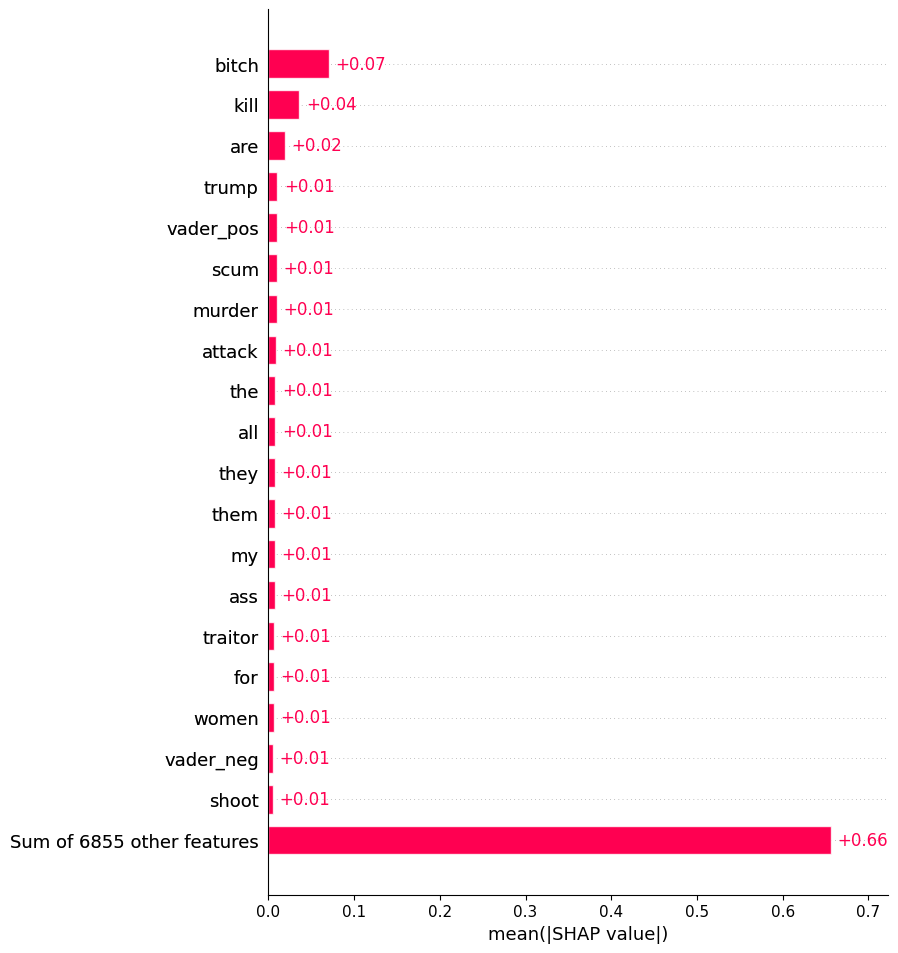

In [33]:
# %%
# Global bar plot (new-style API)

shap.plots.bar(global_exp, max_display=20)

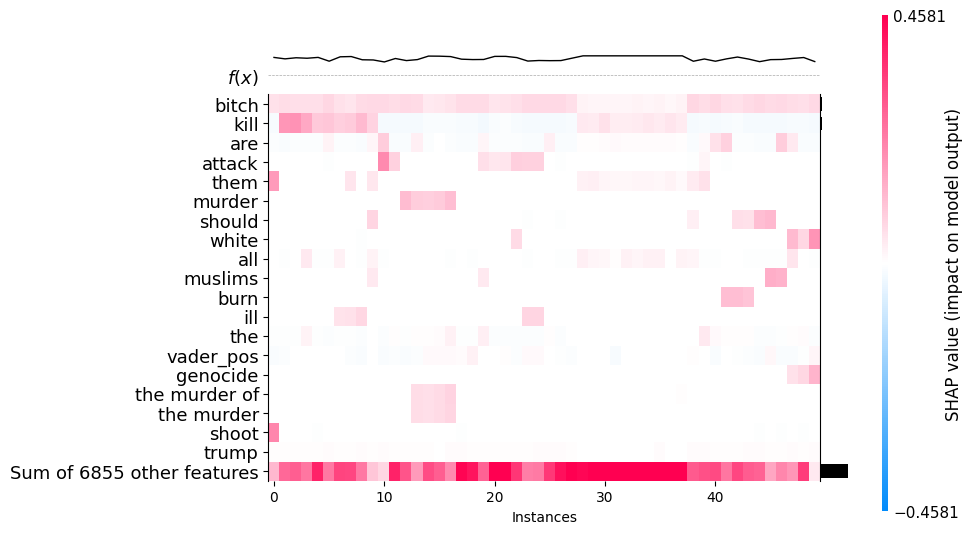

<Axes: xlabel='Instances'>

In [34]:
# %%
# Heatmap of SHAP values for top-N samples by predicted extremism probability

N = min(50, global_exp.values.shape[0])  # top N samples
# Sort by model probability of extremist (highest first)
top_idx = np.argsort(-y_val_pred[:global_exp.shape[0]])[:N]

shap.plots.heatmap(global_exp[top_idx], max_display=20)

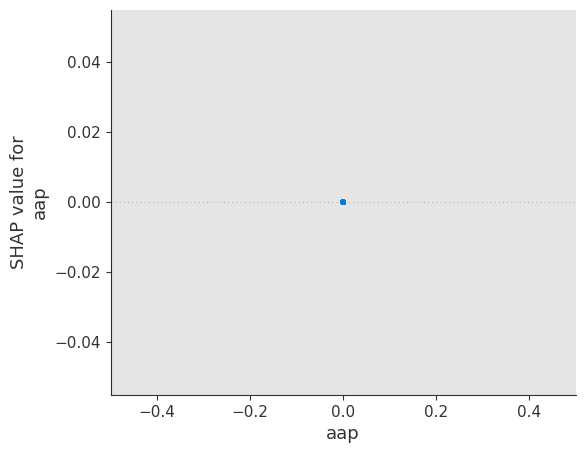

In [35]:
# %%
# Scatter / dependence plot for a chosen feature (new-style)

# After looking at global bar importance, pick a top feature index:
feature_idx = 0  # change this to a more important index

shap.plots.scatter(
    global_exp[:, feature_idx],
    color=global_exp[:, feature_idx]  # color by same feature, or choose another
)

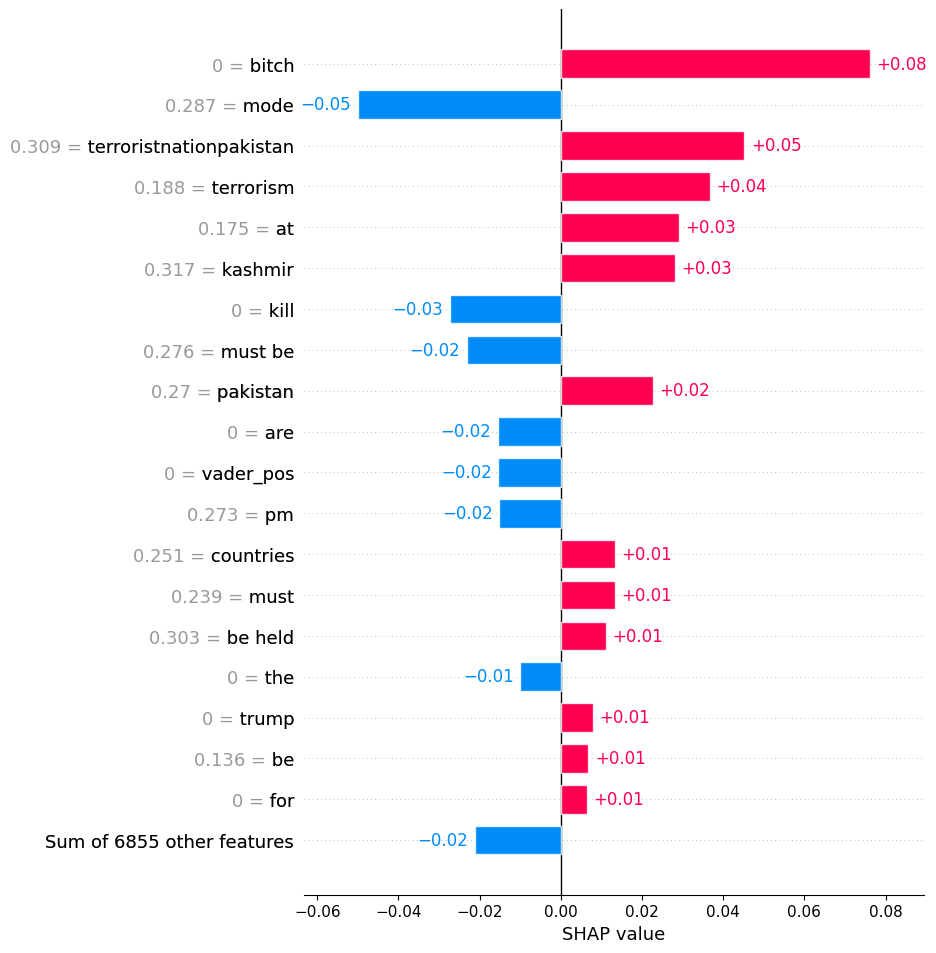

In [36]:
# %%
# Local SHAP bar plot for a single example

i = 0  # index within [0, explain_size)

local_exp = global_exp[i]

shap.plots.bar(local_exp, max_display=20)

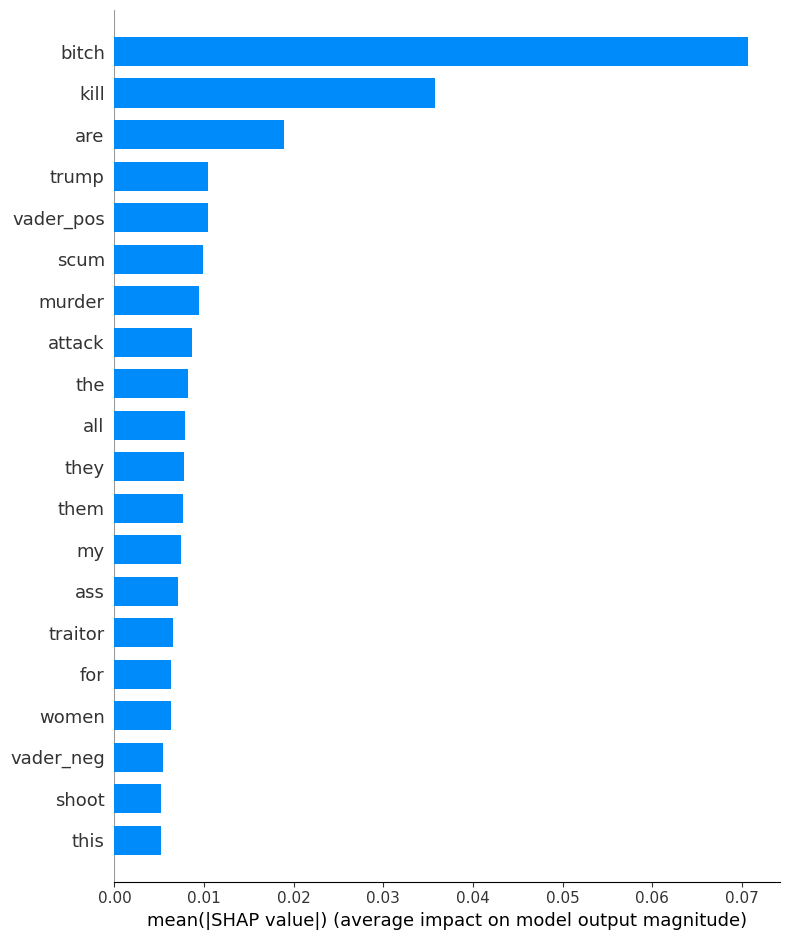

In [16]:
# %%
# 13. Global SHAP importance (mean |SHAP| bar plot)

shap.summary_plot(
    shap_values,
    X_val_explain,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

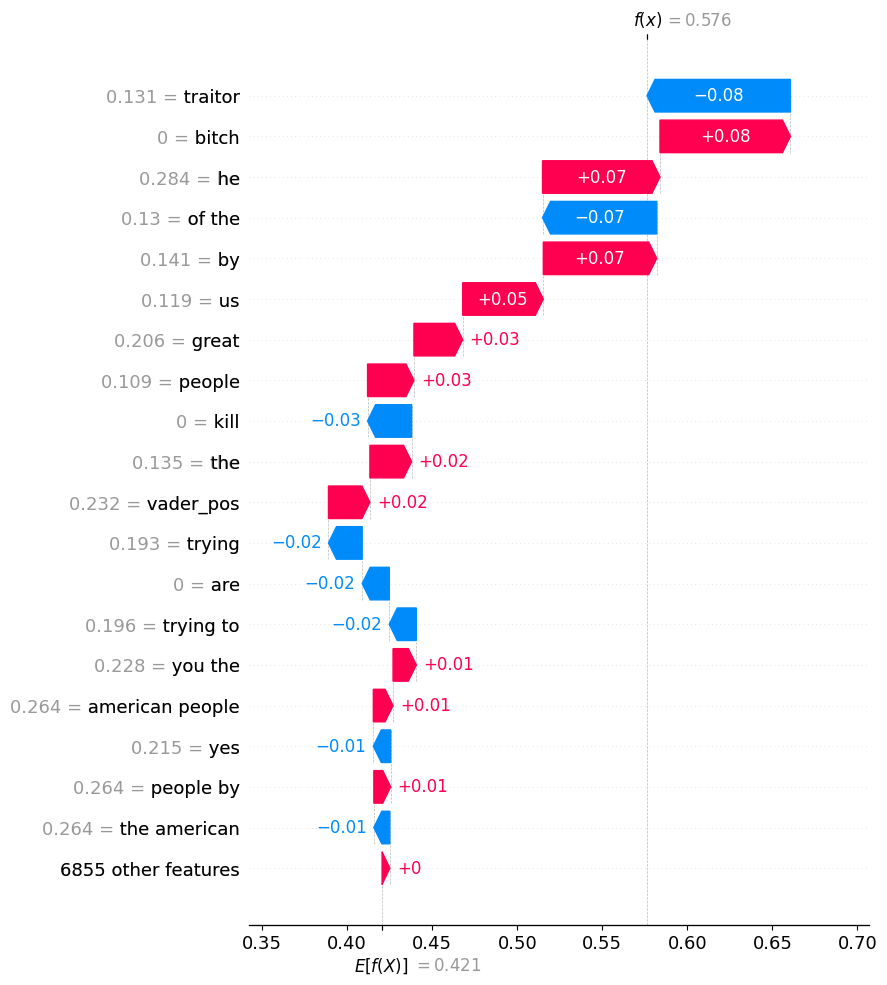

In [24]:
# %%
# Waterfall plot for a single example

# Pick which example (row in X_val_explain) you want to inspect
i = 1  # change this to any index in [0, explain_size)

# Build a SHAP Explanation object for this example
exp = shap.Explanation(
    values=shap_values[i],                 # SHAP values for example i (shape: n_features,)
    base_values=explainer.expected_value,  # model's expected (baseline) output
    data=X_val_explain[i],                 # original feature values for example i
    feature_names=feature_names            # names for each feature
)

# Plot the waterfall
shap.plots.waterfall(
    exp,
    max_display=20   # show top 20 features; increase/decrease as needed
)

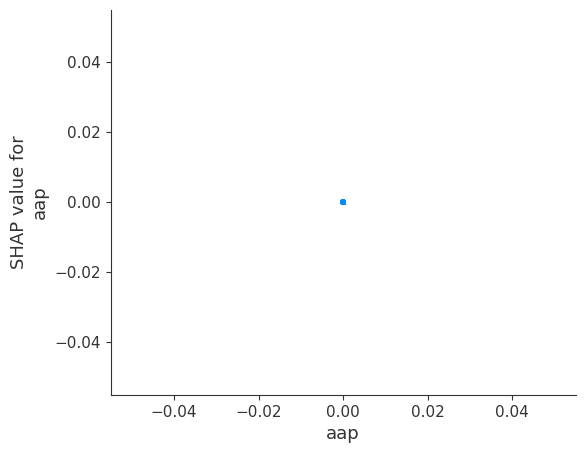

In [17]:
# %%
# 14. SHAP dependence plot for a selected feature

# After inspecting the bar plot, set this to a top feature index
feature_idx = 0  # TODO: replace with actual important feature index

shap.dependence_plot(
    feature_idx,
    shap_values,
    X_val_explain,
    feature_names=feature_names
)

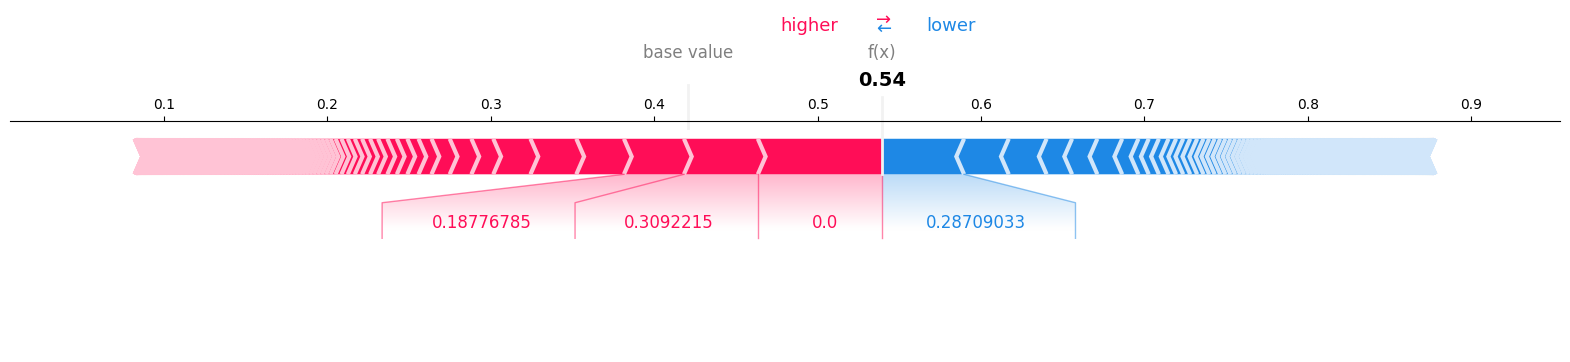

In [37]:
# %%
# 15. Local SHAP force plot for a single example

i = 0  # same index as waterfall if you want

shap.force_plot(
    explainer.expected_value,
    shap_values[i, :],
    X_val_explain[i, :],
    matplotlib=False  # interactive JS (if supported)
)

shap.force_plot(
    explainer.expected_value,
    shap_values[i, :],
    X_val_explain[i, :],
    matplotlib=True   # static fallback
)

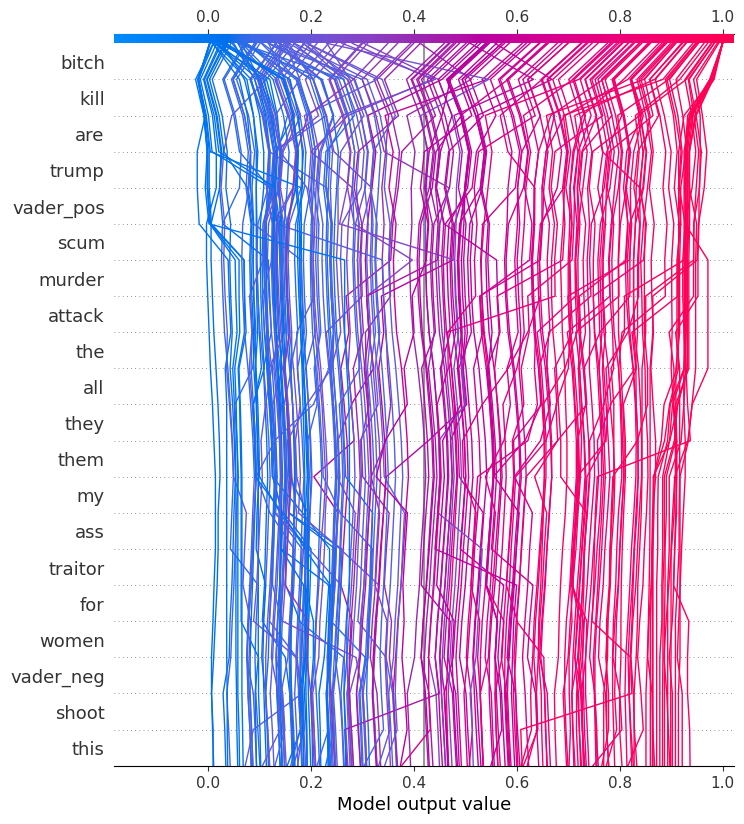

In [19]:
# %%
# 16. SHAP decision plot (optional global view)

shap.decision_plot(
    explainer.expected_value,
    shap_values,
    feature_names=feature_names,
)

In [20]:
# %%
# 17. Use trained model to score all rows and find disagreements

model2.eval()
with torch.no_grad():
    X_all_tensor = torch.from_numpy(X_np)
    y_all_probs = model2(X_all_tensor).cpu().numpy().ravel()

y_all_true = y_np.ravel().astype(int)
y_all_pred = (y_all_probs >= VAL_THRESHOLD).astype(int)

df["model_prob_extremist"] = y_all_probs
df["model_pred_label"] = y_all_pred

disagree_mask = (y_all_true != y_all_pred)
print("Number of disagreements between model and gold label:", disagree_mask.sum())

df_disagree = df.loc[disagree_mask].copy()
df_disagree["true_label"] = y_all_true[disagree_mask]
df_disagree["pred_label"] = y_all_pred[disagree_mask]

df_disagree["model_confidence"] = np.where(
    df_disagree["model_prob_extremist"] >= 0.5,
    df_disagree["model_prob_extremist"],
    1.0 - df_disagree["model_prob_extremist"],
)

df_disagree = df_disagree.sort_values("model_confidence", ascending=False)

df_disagree[[
    "row_id",
    "Original_Message",
    "Extremism_Label",
    "true_label",
    "pred_label",
    "model_prob_extremist",
    "model_confidence",
]].head(20)

Number of disagreements between model and gold label: 227


,row_id,Original_Message,Extremism_Label,true_label,pred_label,model_prob_extremist,model_confidence
1586,1586,qanon cult canons q army thegreatawakening tru...,EXTREMIST,1,0,0.004635,0.995365
275,275,i am going to kill all the coyotes in this park,NON_EXTREMIST,0,1,0.976528,0.976528
1107,1107,real talk if you support you are a russian sym...,EXTREMIST,1,0,0.042451,0.957549
526,526,burn your bra s,NON_EXTREMIST,0,1,0.942067,0.942067
213,213,here whatever go again a population of trapped...,NON_EXTREMIST,0,1,0.932559,0.932559
1470,1470,twelve oclock is the most important thing all ...,NON_EXTREMIST,0,1,0.927930,0.927930
163,163,kill shot easily shows ya why he is a rap god ...,NON_EXTREMIST,0,1,0.923269,0.923269
1058,1058,guests so naive to say and believe traitor tru...,EXTREMIST,1,0,0.077270,0.922731
2641,2641,dharna at the collect orate at alaska i am abo...,NON_EXTREMIST,0,1,0.920139,0.920139
353,353,western media just ignores muslims for the mos...,NON_EXTREMIST,0,1,0.911338,0.911338


In [21]:
# %%
# 18. Save candidate mislabels for manual review

output_path = "potential_mislabels_by_model.csv"
df_disagree.to_csv(output_path, index=False)
print(f"Saved {len(df_disagree)} candidate mislabels to {output_path}")

Saved 227 candidate mislabels to potential_mislabels_by_model.csv
